In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
import kaggle
kaggle.api.dataset_download_files('rtti237/realwaste-dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rtti237/realwaste-dataset


In [5]:
# Verify download
!ls -la

total 24
drwxr-xr-x  1 root root 4096 Oct 29 18:34 .
drwxr-xr-x  1 root root 4096 Oct 29 18:31 ..
drwxr-xr-x  4 root root 4096 Oct 28 13:34 .config
-rw-r--r--  1 root root   69 Oct 29 18:34 kaggle.json
drwxr-xr-x 11 root root 4096 Oct 29 18:34 RealWaste
drwxr-xr-x  1 root root 4096 Oct 28 13:34 sample_data


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import time
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Dataset parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 70
DATA_DIR = './RealWaste'

CLASS_NAMES = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic',
    'Textile Trash', 'Vegetation'
]


Using device: cuda
GPU: Tesla T4


In [7]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                image_files = sorted(class_dir.glob('*.*'))
                for img_path in image_files:
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(str(img_path))
                        self.labels.append(class_idx)
            else:
                print(f"⚠️ Warning: Directory not found: {class_dir}")

        print(f"Loaded {len(self.images)} images from {len(CLASS_NAMES)} classes")

        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
def calculate_mean_std(dataset_path, image_size=224, sample_size=1000):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = torch.utils.data.Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=2)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    print(f"Dataset Mean: [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
    print(f"Dataset Std:  [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")

    return mean.tolist(), std.tolist()

print("\n" + "="*70)
print("CALCULATING DATASET STATISTICS")
print("="*70)
dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)



CALCULATING DATASET STATISTICS
Loaded 4752 images from 9 classes
Dataset Mean: [0.5959, 0.6181, 0.6327]
Dataset Std:  [0.1614, 0.1624, 0.1879]


In [9]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

val_test_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.15)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])


In [10]:
print("\n" + "="*70)
print("LOADING AND SPLITTING DATASET")
print("="*70)

train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)
labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])

# First split: train vs (val + test)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
train_idx, temp_idx = next(sss1.split(np.arange(len(labels)), labels))

# Second split: val vs test
temp_labels = labels[temp_idx]
relative_test_size = test_ratio / (val_ratio + test_ratio)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=relative_test_size, random_state=42)
val_idx_rel, test_idx_rel = next(sss2.split(np.arange(len(temp_idx)), temp_labels))

val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

print(f"\nSplit sizes:")
print(f"  Train: {len(train_idx)} ({len(train_idx)/len(labels)*100:.1f}%)")
print(f"  Val:   {len(val_idx)} ({len(val_idx)/len(labels)*100:.1f}%)")
print(f"  Test:  {len(test_idx)} ({len(test_idx)/len(labels)*100:.1f}%)")

# Create datasets with transforms
train_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=train_transform)
val_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)
test_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)
test_dataset = Subset(test_dataset_full, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, drop_last=False)

print(f"\n✅ DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

print("\n" + "="*70)
print("COMPUTING CLASS WEIGHTS")
print("="*70)

train_labels = labels[train_idx].tolist()
class_counts = Counter(train_labels)
total_train = len(train_labels)

class_weights = torch.tensor(
    [total_train / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)],
    dtype=torch.float32
).to(device)

print("\nClass weights:")
for i, (name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"  {name:20s}: {weight:.3f} (count: {class_counts[i]:3d})")



LOADING AND SPLITTING DATASET
Loaded 4752 images from 9 classes

Split sizes:
  Train: 3326 (70.0%)
  Val:   713 (15.0%)
  Test:  713 (15.0%)
Loaded 4752 images from 9 classes
Loaded 4752 images from 9 classes
Loaded 4752 images from 9 classes

✅ DataLoaders created:
  Train batches: 104
  Val batches:   23
  Test batches:  23

COMPUTING CLASS WEIGHTS

Class weights:
  Cardboard           : 1.144 (count: 323)
  Food Organics       : 1.283 (count: 288)
  Glass               : 1.257 (count: 294)
  Metal               : 0.668 (count: 553)
  Miscellaneous Trash : 1.068 (count: 346)
  Paper               : 1.056 (count: 350)
  Plastic             : 0.573 (count: 645)
  Textile Trash       : 1.665 (count: 222)
  Vegetation          : 1.212 (count: 305)


In [11]:
model = models.densenet121(pretrained=True)

# Fine-tune strategy: Freeze early layers, train later layers
for name, param in model.features.named_parameters():
    if 'denseblock1' in name or 'denseblock2' in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Replace classifier
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

print(f"✅ DenseNet121 loaded")
print(f"   Features frozen: denseblock1, denseblock2")
print(f"   Trainable layers: denseblock3, denseblock4, transition3, classifier")
print(f"   Custom classifier: {num_features} -> 512 -> {NUM_CLASSES}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]


✅ DenseNet121 loaded
   Features frozen: denseblock1, denseblock2
   Trainable layers: denseblock3, denseblock4, transition3, classifier
   Custom classifier: 1024 -> 512 -> 9


In [12]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-3, 5e-3],
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

print("✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights")
print("✅ Optimizer: AdamW with differential learning rates")
print("   - Features: 1e-4")
print("   - Classifier: 1e-3")
print("✅ Scheduler: OneCycleLR (cosine annealing)")



TRAINING CONFIGURATION
✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights
✅ Optimizer: AdamW with differential learning rates
   - Features: 1e-4
   - Classifier: 1e-3
✅ Scheduler: OneCycleLR (cosine annealing)


In [13]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        self.best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}

early_stopping = EarlyStopping(patience=15)
print("✅ Early stopping: patience=15")


✅ Early stopping: patience=15


In [14]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, lbls in dataloader:
        images, lbls = images.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, lbls)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, lbls in dataloader:
            images, lbls = images.to(device), lbls.to(device)
            outputs = model(images)
            loss = criterion(outputs, lbls)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [15]:
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'lr': []
}

best_val_acc = 0.0
best_epoch = 0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] ({epoch_time:4.1f}s) | "
          f"LR: {current_lr:.6f} | "
          f"Train: {train_acc:5.2f}% | "
          f"Val: {val_acc:5.2f}%", end='')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, 'best_densenet121.pth')
        print(" ✨ BEST!", end='')

    print()

    if epoch > 0:
        if val_acc >= 90 and history['val_acc'][-2] < 90:
            print("   🎯 90% accuracy reached!")
        elif val_acc >= 93 and history['val_acc'][-2] < 93:
            print("   🎉 93% - Excellent!")
        elif val_acc >= 95 and history['val_acc'][-2] < 95:
            print("   🏆 95%+ OUTSTANDING!")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"\nℹ️  Early stopping at epoch {epoch+1}")
        break

total_time = time.time() - start_time

print("\n" + "="*70)
print("✅ TRAINING COMPLETE")
print("="*70)
print(f"⏱️  Total time: {total_time/60:.1f} min")
print(f"🏆 Best val accuracy: {best_val_acc:.2f}%")
print(f"📍 Best epoch: {best_epoch}")
print(f"💾 Model saved: best_densenet121.pth")
print("="*70)


Epoch [  1/70] (66.9s) | LR: 0.000045 | Train: 34.79% | Val: 61.43% ✨ BEST!
Epoch [  2/70] (55.1s) | LR: 0.000061 | Train: 60.16% | Val: 76.02% ✨ BEST!
Epoch [  3/70] (53.5s) | LR: 0.000088 | Train: 70.20% | Val: 81.35% ✨ BEST!
Epoch [  4/70] (55.0s) | LR: 0.000123 | Train: 74.68% | Val: 83.59% ✨ BEST!
Epoch [  5/70] (54.7s) | LR: 0.000168 | Train: 77.63% | Val: 84.29% ✨ BEST!
Epoch [  6/70] (54.2s) | LR: 0.000221 | Train: 81.90% | Val: 84.15%
Epoch [  7/70] (56.0s) | LR: 0.000280 | Train: 83.31% | Val: 86.68% ✨ BEST!
Epoch [  8/70] (54.1s) | LR: 0.000345 | Train: 83.13% | Val: 84.57%
Epoch [  9/70] (54.0s) | LR: 0.000413 | Train: 82.26% | Val: 81.07%
Epoch [ 10/70] (54.2s) | LR: 0.000484 | Train: 81.99% | Val: 83.03%
Epoch [ 11/70] (54.3s) | LR: 0.000556 | Train: 83.61% | Val: 84.43%
Epoch [ 12/70] (54.7s) | LR: 0.000627 | Train: 82.23% | Val: 83.45%
Epoch [ 13/70] (56.6s) | LR: 0.000696 | Train: 82.83% | Val: 78.82%
Epoch [ 14/70] (54.7s) | LR: 0.000760 | Train: 82.38% | Val: 81.77%


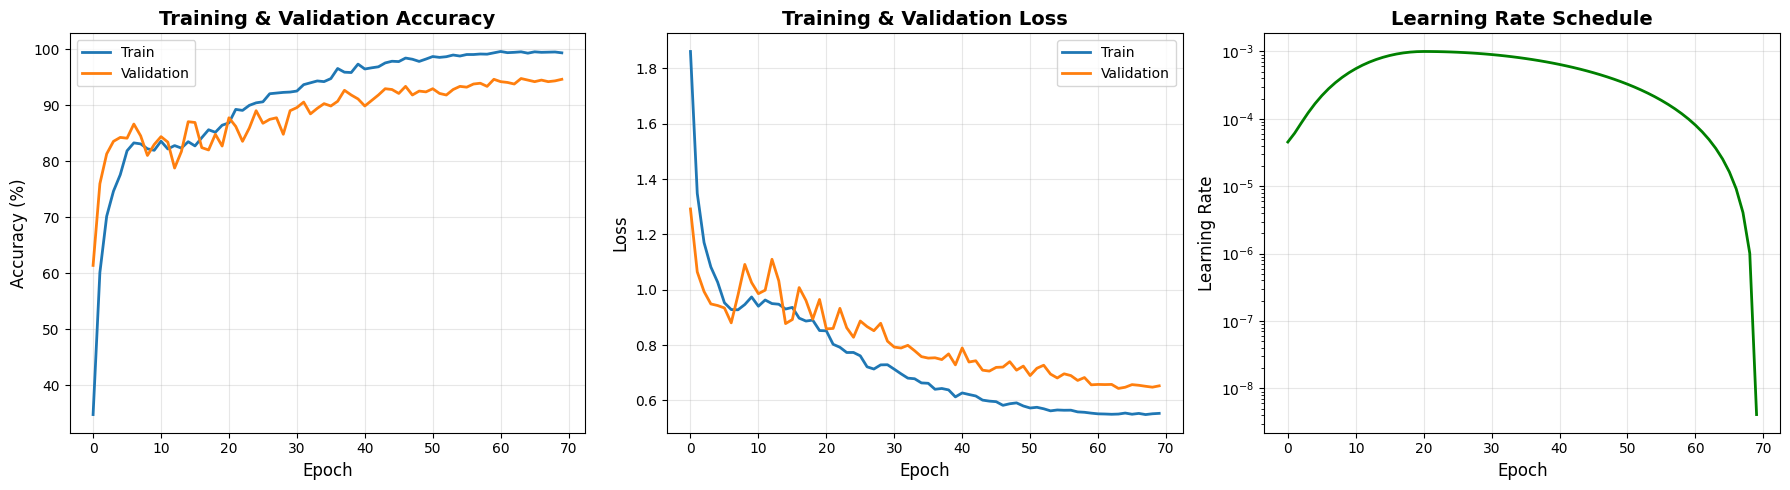


📊 Training curves saved as 'training_curves.png'


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history['train_acc'], label='Train', linewidth=2)
axes[0].plot(history['val_acc'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history['train_loss'], label='Train', linewidth=2)
axes[1].plot(history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Training curves saved as 'training_curves.png'")

In [17]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
checkpoint = torch.load('best_densenet121.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"\n🎯 Test Accuracy: {test_acc:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


EVALUATING ON TEST SET

🎯 Test Accuracy: 94.25%
📉 Test Loss: 0.6490


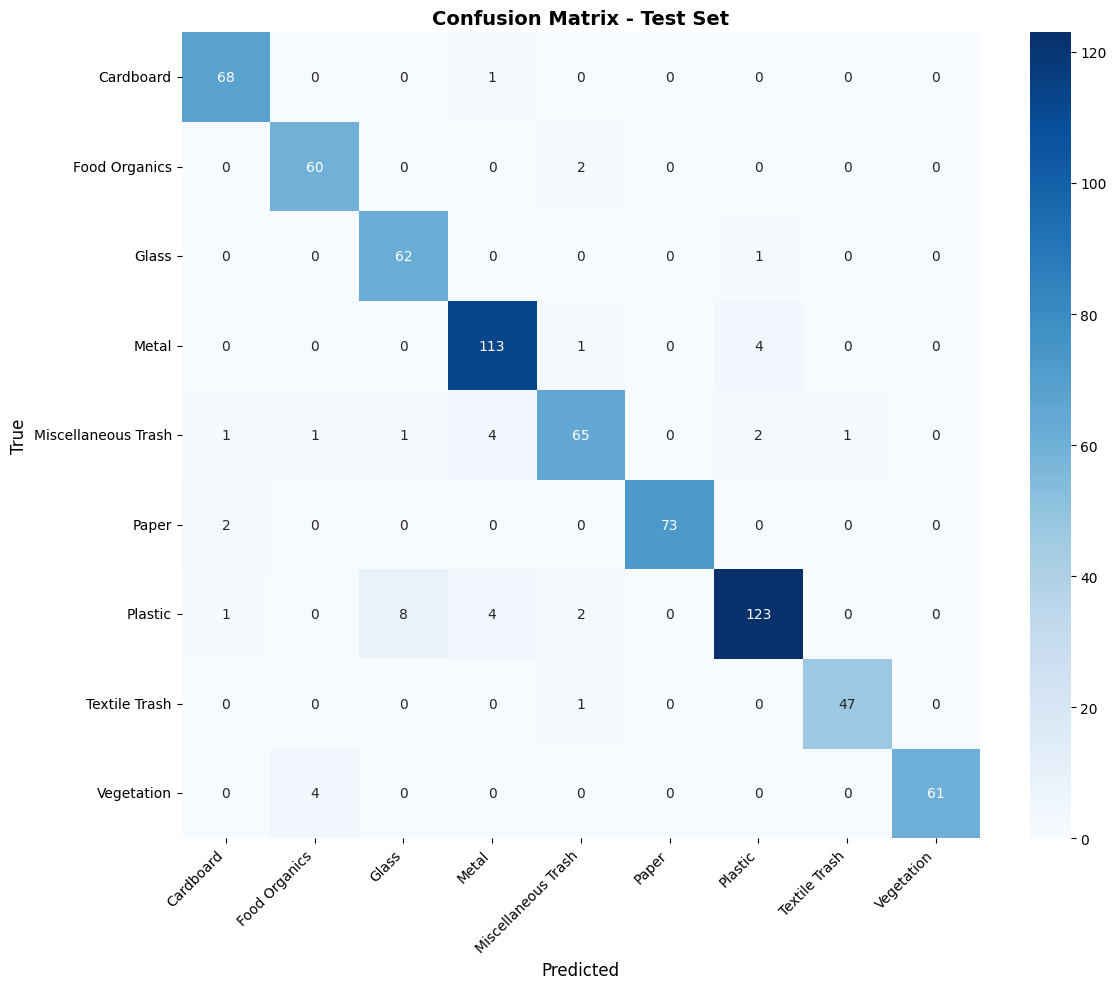


📊 Confusion matrix saved as 'confusion_matrix.png'

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard       0.94      0.99      0.96        69
      Food Organics       0.92      0.97      0.94        62
              Glass       0.87      0.98      0.93        63
              Metal       0.93      0.96      0.94       118
Miscellaneous Trash       0.92      0.87      0.89        75
              Paper       1.00      0.97      0.99        75
            Plastic       0.95      0.89      0.92       138
      Textile Trash       0.98      0.98      0.98        48
         Vegetation       1.00      0.94      0.97        65

           accuracy                           0.94       713
          macro avg       0.95      0.95      0.95       713
       weighted avg       0.94      0.94      0.94       713



In [18]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, lbls in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Confusion matrix saved as 'confusion_matrix.png'")

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))